<a href="https://colab.research.google.com/github/riquelmev/Personal-Projects/blob/master/Big_Data_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


```
# This is formatted as code
```

]

In [ ]:
import requests

# grab Post Game Threads from specific team

In [ ]:
!pip install praw
import praw
!pip install flair

     |████████████████████████████████| 153kB 5.8MB/s 
     |████████████████████████████████| 204kB 29.7MB/s 
     |████████████████████████████████| 337kB 5.9MB/s 
     |████████████████████████████████| 19.7MB 1.2MB/s 
     |████████████████████████████████| 798kB 44.2MB/s 
     |████████████████████████████████| 1.3MB 47.2MB/s 
     |████████████████████████████████| 71kB 9.1MB/s 
     |████████████████████████████████| 1.1MB 44.5MB/s 
     |████████████████████████████████| 983kB 45.7MB/s 
     |████████████████████████████████| 2.9MB 42.2MB/s 
     |████████████████████████████████| 890kB 46.3MB/s 
  Created wheel for segtok: filename=segtok-1.5.10-cp36-none-any.whl size=25021 sha256=59b7e34550902e53afaf0d7738d5212cf845a9e1b3cf64ebf102c06cf69bced8
  Stored in directory: /root/.cache/pip/wheels/b4/39/f6/9ca1c5cabde964d728023b5751c3a206a5c8cc40252321fb6b
  Created wheel for mpld3: filename=mpld3-0.3-cp36-none-any.whl size=116677 sha256=462ff741f3ea9fad0a377b768e35d0d262861508da3793

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize
import praw
import matplotlib.pyplot as plt
import spacy
from flair.models import TextClassifier
from flair.data import Sentence
from segtok.segmenter import split_single
import datetime as dt
from datetime import timezone
import pandas as pd
import re
from textblob import TextBlob
from tqdm import tqdm

nltk.download('vader_lexicon')
nltk.download('punkt')

#classifier = TextClassifier.load('en-sentiment')
# 

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from datetime import datetime
import pandas as pd

team_dict_for_url= {
    'DenverBroncos': 'den',
    'Patriots': 'nwe',
    'Browns': 'cle',
    'KansasCityChiefs': 'kan',
    'nyjets': 'nyj'
}
def wins_and_losses(team, year):
    #generate url 
    team_abrev = team_dict_for_url[team]
    url = 'https://www.pro-football-reference.com/teams/' + team_abrev + '/' + str(year) + '.htm#games::none'
    
    #pandas table
    season_stats = pd.read_html(url)[1]
    
    #gets wins and losses for that season in a list sequentially
    #if the team had a bye week, or the game has not happened yet (2020 season), 'nan' will be added
    win_loss_index = season_stats["Unnamed: 5_level_0"]["Unnamed: 5_level_1"]
    win_loss_list = []
    for i in range(17):
        win_loss_list.append(win_loss_index[i])
    
    #getting the dates for those games
    dates_to_index = season_stats["Unnamed: 2_level_0"]
    dates = dates_to_index["Date"]
    date_list = []
    formatted_date_list = []
    for i in range(17):
        non_formatted_date = str(dates[i])+ ", " + str(year)
        #date_list.append(str(dates[i])+ ", " + str(year))
        
        try:
            split = non_formatted_date.split()

            year = int(split[2])
            month = split[0]
            #increase year if 2020
            if month == "January":
              year += 1
            #replace
            split[2] = str(year)
            non_formatted_date = " ".join(split)

            formatted_date = datetime.strptime(non_formatted_date, "%B %d, %Y")
            #print(formatted_date)
            
            
            #convert to unix timestamp
            unix_timestamp = formatted_date.replace(tzinfo=timezone.utc).timestamp()
            #print(unix_timestamp)

            #print(formatted_date_list)            
        except:
            unix_timestamp = "nan"
        formatted_date_list.append(unix_timestamp)
    
    date_win_loss_dict = {}
    for i in range(len(formatted_date_list)):
        date =formatted_date_list[i]
        outcome = win_loss_list[i]
        if outcome == "W":
          outcome_int = 1
        elif outcome == "L":
          outcome_int = 0
        else:
          outcome_int = -1
        date_win_loss_dict[date] = outcome_int
    return (date_win_loss_dict)

print(wins_and_losses("DenverBroncos", 2020))
print(wins_and_losses("DenverBroncos", 2019))

{1600041600.0: 0, 1600560000.0: 0, 1601164800.0: 0, 1601510400.0: 1, 'nan': -1, 1602979200.0: 1, 1603584000.0: 0, 1604188800.0: 1, 1604793600.0: 0, 1605398400.0: 0, 1606003200.0: 1, 1606608000.0: -1, 1607212800.0: -1, 1607817600.0: -1, 1608336000.0: -1, 1609027200.0: -1, 1609632000.0: -1}
{1567987200.0: 0, 1568505600.0: 0, 1569110400.0: 0, 1569715200.0: 0, 1570320000.0: 1, 1570924800.0: 1, 1571270400.0: 0, 1572134400.0: 0, 1572739200.0: 1, 'nan': -1, 1573948800.0: 0, 1574553600.0: 0, 1575158400.0: 1, 1575763200.0: 1, 1576368000.0: 0, 1576972800.0: 1, 1577577600.0: 1}


In [ ]:
def get_cumulative_post_sentiment(post, analyzer="vader"):
  total_comments = 0
  total_sentiment = {"pos": 0, "neg": 0, "neu": 0}
  sentiment_list = []
  post.comments.replace_more(limit=None)

  # Split into sentences, analyze each, average across
  text = "\n".join([comment.body for comment in post.comments])
  tokenized_sentences = sent_tokenize(text)
  for sentence in tqdm(tokenized_sentences):
    sentiment = get_sentiment(sentence, analyzer)
    total_sentiment["pos"] += sentiment["pos"]
    total_sentiment["neg"] += sentiment["neg"]
    total_sentiment["neu"] += sentiment["neu"]
    total_comments += 1
    sentiment_list.append(sentiment)
    # print(sentiment)
  for sentiment in total_sentiment.keys():
    total_sentiment[sentiment] /= total_comments
  return total_sentiment, sentiment_list

def get_sentiment(sentence, analyzer):
  if analyzer == "vader":
    model = SentimentIntensityAnalyzer()
    sentiment = model.polarity_scores(sentence)
  elif analyzer == "textblob":
    sentiment = {}
    text = TextBlob(sentence)
    polarity = (text.sentiment.polarity + 1) / 2
    sentiment["pos"] = polarity
    sentiment["neg"] = 1 - polarity
    sentiment["neu"] = 0
  elif analyzer == "flair":
    text = Sentence(sentence)
    # stacked_embeddings.embed(text)
    classifier.predict(text)
    value = text.labels[0].to_dict()['value'] 
    sentiment = {}
    result = round(text.to_dict()['labels'][0]['confidence'], 4)
    if value == 'POSITIVE':
      sentiment["pos"] = result
      sentiment["neg"] = 1 - result
    else:
      sentiment["pos"] = 1 - result
      sentiment["neg"] = result
    sentiment["neu"] = 0
    return sentiment
    
    
  return sentiment

In [ ]:
reddit = praw.Reddit(client_id='Vrciy8Lso6cNXw', client_secret='qR1_JCYeniK6iViLxk9RpAg0XN6DIQ', user_agent='Gimme Threads')
teamDict:{
    "broncos":"DenverBroncos"
}

def get_team_history(team, depth=5):
  team_history = []
  i = 0
  post_game_threads = reddit.subreddit(team).search("Post Game Thread")
  for post in tqdm(post_game_threads):
    if i < depth or depth < 0:
      total_sentiment, sentiment_list = get_cumulative_post_sentiment(post, analyzer="flair")
      # total_sentiment = {"pos": 1, "neg": 0, "neu": 0}
      # sentiment_list = ["empty sentiment list"]
      game_summary = {
        "title": post.title,
        "reddit_date": dt.datetime.fromtimestamp(int(post.created)).replace(tzinfo=timezone.utc).timestamp(),
        "nfl_date": 0,
        "readable_date": 00-00-00,
        "win": -1,
        "pos_sentiment": total_sentiment["pos"],
        "neg_sentiment": total_sentiment["neg"],
        "neu_sentiment": total_sentiment["neu"],
        "sentiment_list": sentiment_list
      }
      team_history.append(game_summary)
      i += 1

  return team_history

#test = get_team_history("DenverBroncos", depth=1)

In [ ]:
def add_win_loss_data(team_history, win_loss_data):
  for key, value in win_loss_data.items():
    for game in team_history:
      if key != "nan":
        if int(key) < game["reddit_date"] < int(key) + (48*60*60):
          game["win"] = value
          game["nfl_date"] = key
          game["readable_date"] = dt.datetime.fromtimestamp(game["reddit_date"]).strftime("%Y-%m-%d")

win_loss_data = wins_and_losses("DenverBroncos", 2019)
win_loss_data = wins_and_losses("DenverBroncos", 2020)
add_win_loss_data(test, win_loss_data)

for i in test:
  print(i)

{'title': 'Post Game Thread: Miami Dolphins (6-3) @ Denver Broncos (3-6)', 'reddit_date': 1606119045.0, 'nfl_date': 1606003200.0, 'readable_date': '2020-11-23', 'win': 1, 'pos_sentiment': 1, 'neg_sentiment': 0, 'neu_sentiment': 0, 'sentiment_list': ['empty sentiment list']}
{'title': 'Post Game Thread: Denver Broncos (3-5) @ Las Vegas Raiders (5-3)', 'reddit_date': 1605515125.0, 'nfl_date': 1605398400.0, 'readable_date': '2020-11-16', 'win': 0, 'pos_sentiment': 1, 'neg_sentiment': 0, 'neu_sentiment': 0, 'sentiment_list': ['empty sentiment list']}
{'title': 'Post Game Thread: Los Angeles Chargers (2-4) @ Denver Broncos (3-4)', 'reddit_date': 1604306024.0, 'nfl_date': 1604188800.0, 'readable_date': '2020-11-02', 'win': 1, 'pos_sentiment': 1, 'neg_sentiment': 0, 'neu_sentiment': 0, 'sentiment_list': ['empty sentiment list']}
{'title': 'Post Game Thread: Denver Broncos (3-4) @ Atlanta Falcons (2-6)', 'reddit_date': 1604899026.0, 'nfl_date': 1604793600.0, 'readable_date': '2020-11-09', 'win

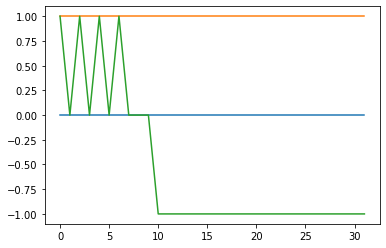

In [ ]:
neg_sentiment = [summary["neg_sentiment"] for summary in test]
pos_sentiment = [summary["pos_sentiment"] for summary in test]
wins = [summary["win"] for summary in test]


plt.plot(neg_sentiment)
plt.plot(pos_sentiment)
plt.plot(wins)
plt.title = "Sentiment Over Time"
plt.ylabel = "Score"
plt.xlabel = "Date"
plt.show()


In [ ]:
teams_list = ["DenverBroncos", 
              "KansasCityChiefs", 
              "nyjets", 
              "Browns", 
              "Patriots",
              "steelers", 
              "eagles", 
              "bengals", 
              "Seahawks"
             ]

#teams_list = ["DenverBroncos"]
year_list = [2020, 2019, 2018]
teams_dict = {}

#last 16 reddit post game threads

for team in teams_list:
  #growing list of dictionaries
  team_history = get_team_history(team, depth=32) # Set depth to past games
  for year in year_list:
    win_loss_data = wins_and_losses(team, year)
    add_win_loss_data(team_history, win_loss_data)
   
  neg_sentiment = [summary["neg_sentiment"] for summary in team_history]
  pos_sentiment = [summary["pos_sentiment"] for summary in team_history]
  total_sentiment = [summary["sentiment_list"] for summary in team_history]
  date = [summary["readable_date"] for summary in team_history]
  wins = [summary["win"] for summary in team_history]
  titles = [summary["title"] for summary in team_history]

  teams_dict[team] = {"title": titles, "pos": pos_sentiment, "neg": neg_sentiment, "win": wins, "date": date, "total_sentiment": total_sentiment}

import json
with open('team_histories_9_JSON.json', 'w') as outfile:
    json.dump(teams_dict, outfile)

Streaming output truncated to the last 5000 lines.



 30%|███       | 114/379 [00:07<00:16, 16.23it/s]



 31%|███       | 116/379 [00:07<00:15, 17.17it/s]



 31%|███       | 118/379 [00:07<00:15, 17.10it/s]



 32%|███▏      | 120/379 [00:07<00:17, 15.03it/s]



 32%|███▏      | 122/379 [00:08<00:16, 15.15it/s]



 33%|███▎      | 124/379 [00:08<00:17, 15.00it/s]



 33%|███▎      | 126/379 [00:08<00:17, 14.08it/s]



 34%|███▍      | 128/379 [00:08<00:18, 13.40it/s]



 34%|███▍      | 130/379 [00:08<00:17, 14.47it/s]



 35%|███▍      | 132/379 [00:08<00:16, 15.36it/s]



 35%|███▌      | 134/379 [00:08<00:15, 15.92it/s]



 36%|███▌      | 136/379 [00:08<00:14, 16.58it/s]



 36%|███▋      | 138/379 [00:09<00:14, 16.74it/s]



 37%|███▋      | 141/379 [00:09<00:13, 17.48it/s]



 38%|███▊      | 144/379 [00:09<00:13, 17.72it/s]



 39%|███▊      | 146/379 [00:09<00:14, 15.79it/s]



 39%|███▉      | 148/379 [00:09<00:14, 15.78it/s]



 40%|███▉      | 150/379 [00:09<00:14, 15.43i

In [ ]:
import json
with open('team_histories_JSON.json', 'w') as outfile:
    json.dump(teams_dict, outfile)

NameError: ignored

In [ ]:
import json

with open('team_histories_JSON.json') as json_file: 
    teams_dict = json.load(json_file)
    
def sorttime(teams_dict, team):
    #sorttime = {}
   # for date in data[team]['date']:
        #sorttime[date]=data[team]['pos']
        res = {teams_dict[team]['date'][i]: teams_dict[team]['pos'][i] for i in range(len(teams_dict[team]['date']))} 

        return res

FileNotFoundError: ignored

In [ ]:
print(teams_dict["DenverBroncos"]["win"])

[1, 0, 1, 0, 0]


In [ ]:
for team in teams_dict.keys():
  plt.plot(teams_dict[team]["pos"], label=team)
print(teams_dict["DenverBroncos"]["win"])
print(teams_dict["Patriots"]["win"])
plt.title = "Sentiment Over Time"
plt.legend(loc='best')
plt.figure(figsize=(10, 10))
plt.show()

NameError: ignored

In [ ]:
plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')   
plt.title = "Sentiment Over Time"

for team in teams_dict.keys():
    #if team == "DenverBroncos" or team == "KansasCityChiefs":
    plt.plot(teams_dict[team]["pos"], label=team)

plt.legend(loc='best')
plt.show()

In [ ]:
# Plot of sentiment across time for different teams, along with horizontal lines 
# showing their average positivity on wins, losses, and total. 

def get_win_loss_sentiment(team_dict):
    win_sentiment = []
    loss_sentiment = []
    avg_sentiment = []
    for i, outcome in enumerate(team_dict["win"]):
        if outcome == 1:
            win_sentiment.append(team_dict["pos"][i])
        elif outcome == 0:
            loss_sentiment.append(team_dict["pos"][i])
    avg_win_sent = sum(win_sentiment) / len(win_sentiment)
    avg_loss_sent = sum(loss_sentiment) / len(loss_sentiment)
    avg_total_sent = (sum(win_sentiment) + sum(loss_sentiment)) / (len(win_sentiment) + len(loss_sentiment))
    return avg_win_sent, avg_loss_sent, avg_total_sent

plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')

 
for i, team in enumerate(teams_dict.keys()):
    sdict = sorttime(teams_dict, team)
    #print (sdict)
    x = (teams_dict[team]['date'])
    #print (x)
    while 0 in x:
        x.remove(0)
    #print (team,x)
    #for thing in x:
    #    print (type(thing))
    x = sorted(x)
    #print (team,x)
    y = []
    for date in x:
        y.append(sdict[date])
    plt.subplot(3, 5, i+1)
    plt.title(team.capitalize())
    plt.plot(y)
    win, loss, total = get_win_loss_sentiment(teams_dict[team])
    plt.plot([win for i in range(len(y))])
    plt.plot([loss for i in range(len(y))])
    plt.plot([total for i in range(len(y))])
    plt.ylim(.2, .8)
    print("\n" + team)
    print("average happiness:", total)
    print("average happiness when controlling for wins and losses", win+loss/2)
    print("mood swing:", win-loss)
    
    #print (team,x,y)

NameError: ignored

In [ ]:
with open('team_histories_JSON2.json') as json_file:
    data = json.load(json_file)

FileNotFoundError: ignored

In [ ]:
#Boxplot
import matplotlib.pyplot as plt
box = []
for date in data[team]['total_sentiment']:
    boxtemp = []
    for comment in date:
        boxtemp.append(comment['pos'])
    box.append(boxtemp)
plt.boxplot(box)
plt.show()

In [ ]:
#Line Graph
for team in data.keys():
    y = (data[team]['pos'])
    x = (data[team]['date'])
    plt.plot(x,y)
plt.show()

NameError: ignored

In [ ]:
# sort time
import matplotlib.pyplot as plt
def sorttime(team):
    #sorttime = {}
   # for date in data[team]['date']:
        #sorttime[date]=data[team]['pos']
        res = {data[team]['date'][i]: data[team]['pos'][i] for i in range(len(data[team]['date']))} 

        return res
    

for team in data.keys():
    sdict = sorttime(team)
    #print (sdict)
    x = (data[team]['date'])
    #print (x)
    while 0 in x:
        x.remove(0)
    print (x)
    #print (team,x)
    #for thing in x:
    #    print (type(thing))
    x = sorted(x)
    #print (team,x)
    y = []
    for date in x:
        y.append(sdict[date])
    plt.plot(y)
    #print (team,x,y)

        
plt.show()

NameError: ignored

In [ ]:
# sort time
import matplotlib.pyplot as plt
def sorttime(team):
    #sorttime = {}
   # for date in data[team]['date']:
        #sorttime[date]=data[team]['pos']
        res = {data[team]['date'][i]: data[team]['pos'][i] for i in range(len(data[team]['date']))} 

        return res
    

for team in data.keys():
    sdict = sorttime(team)
    x = (data[team]['date'])
    #print (team,x)
    x = sorted(x)
    #print (team,x)
    y = []
    for date in x:
        y.append(sdict[date])
    plt.plot(x,y)
    print (team,x,y)

        
plt.show()

In [ ]:
# Bargraph 
def get_win_loss_sentiment(team):
    win_sentiment = []
    loss_sentiment = []
    avg_sentiment = []
    for i, outcome in enumerate(data[team]["win"]):
        if outcome == 1:
            win_sentiment.append(data[team]["pos"][i])
        elif outcome == 0:
            loss_sentiment.append(data[team]["pos"][i])
    avg_win_sent = sum(win_sentiment) / len(win_sentiment)
    avg_loss_sent = sum(loss_sentiment) / len(loss_sentiment)
    avg_total_sent = (sum(win_sentiment) + sum(loss_sentiment)) / (len(win_sentiment) + len(loss_sentiment))
    return avg_win_sent, avg_loss_sent, avg_total_sent

team_name = []
team_data = []
for team in data.keys():
    win_sent, loss_sent, avg_sent = get_win_loss_sentiment(team)
    winlossavg = [win_sent, loss_sent, avg_sent]
    team_name.append(team)
    team_data.append(winlossavg)
df = pd.DataFrame(team_data, index=team_name)
df.columns =['Win Avg', 'Lose Avg', 'Avg'] 
print (df)
df.plot.bar()


In [ ]:
slist = []
for team in teams_list:
  team_history = get_team_history(team, depth=10)
  slist = summary["sentiment_list"] for summary in team_history
plot = DataFrame(slist)
#plot.columns = range(1,13)
plot.boxplot()
pyplot.show()





In [ ]:
import re, os
import nltk  
import numpy as np    
import re
from collections import Counter

In [ ]:
for team in teams_list:
  team_history = get_team_history(team, depth=10)
  text = [summary["text"] for summary in team_history]
  print(text)


NameError: ignored

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
def cleantext(text)
  tokens = word_tokenize(text)
  # convert to lower case
  tokens = [w.lower() for w in tokens]
  # remove punctuation from each word
  import string
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  # remove remaining tokens that are not alphabetic
  words = [word for word in stripped if word.isalpha()]
  # filter out stop words
  stop_words = set(stopwords.words('english'))
  words = [w for w in words if not w in stop_words]
  return words

In [ ]:
corpus = []
target = []
name = []
#for each character, add its list of words to the corpus as its faction to the target array
for team in teams_list:
  team_history = get_team_history(team, depth=10)
  for summary in team_history:
    text = summary["text"]
    text = cleantext(text)
    corpus.append(text)
    target.append(team)
  

NameError: ignored

In [ ]:
totalVocabUse = {}
for word in corpus:
    if word not in totalVocabUse.keys():
        totalVocabUse[word] = 1
    else:
         totalVocabUse[word] += 1
#remove the words that are only used for one character
totalVocabUse = {word:count for word, count in totalVocabUse.items() if count != 1}

#make the keys into a sorted list so it stays in order when we iterate through them
vocabList = list(totalVocabUse.keys())
vocabList.sort()

In [ ]:
sentence_vectors = []
for sentence in corpus:
    sentence_tokens = cleantext(sentence)
    sent_vec = []
    for token in totalVocabUse:
        if token in sentence_tokens:
            sent_vec.append(1)
        else:
            sent_vec.append(0)
    sentence_vectors.append(sent_vec)

In [ ]:
#do TFIDF

Link for learning how to iterate through comments: https://praw.readthedocs.io/en/stable/tutorials/comments.html